<a href="https://colab.research.google.com/github/noedelb/eccd_assignments/blob/main/Datathon_versi%C3%B3n_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATATHON  2024**
### **MODELO DE PREDICCIÓN DE DEMANDA DE PRODUCTOS**



Florencia Britos - Noelia Delbono - Sofía Harley

In [1]:
pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 37.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 23.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 k

In [131]:
pip install tslearn

ERROR: Operation cancelled by user


In [3]:
# Importación de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from pycaret.clustering import *
from pycaret.regression import *
import matplotlib.pyplot as plt
from pycaret.time_series import TSForecastingExperiment
import seaborn as sns
from tslearn.clustering import TimeSeriesKMeans
from sklearn.decomposition import PCA

In [4]:
# Carga de archivos Excel

promo = pd.read_excel("ProdEnPromo-UM.xls")
prod = pd.read_excel("Producto-UM.xls")
ventas = pd.read_excel("VentasPR.xlsx")

In [5]:
# Renombramos las variables

promo.rename(columns={'PRDCODEXT': 'SKU'}, inplace=True)
prod.rename(columns={'Cod': 'SKU'}, inplace=True)
ventas.rename(columns={'PRDCODEXT':'SKU','ACPRCANTVEND':'CANTIDAD','ACPRIMPVEN':'FACTURACION'}, inplace=True)

In [6]:
# Se transforma la variable MOVFEC a datetime

ventas['MOVFEC'] = pd.to_datetime(ventas['MOVFEC'], format='%d/%m/%Y')

In [7]:
# Join dfs

df_parcial = pd.merge(ventas, prod, on='SKU', how='left')
df_parcial

,LOCCOD,MOVFEC,SKU,CANTIDAD,FACTURACION,Status Hoy,Prov,Cat,Tipo Prov
0,5201,2021-05-02,600790,7,1393,1.0,31064.0,216.0,1.0
1,5201,2021-05-02,600793,2,390,1.0,31064.0,216.0,1.0
2,5201,2021-05-02,600794,7,2023,1.0,31064.0,216.0,1.0
3,5201,2021-05-02,605089,1,399,1.0,22010.0,216.0,1.0
4,5201,2021-05-02,605097,1,565,5.0,10145.0,216.0,1.0
...,...,...,...,...,...,...,...,...,...
145271,5201,2024-04-30,600917,4,2320,1.0,10145.0,216.0,1.0
145272,5201,2024-04-30,600918,1,580,1.0,10145.0,216.0,1.0
145273,5201,2024-04-30,600919,1,580,5.0,10145.0,216.0,1.0
145274,5201,2024-04-30,600922,1,379,1.0,10214.0,216.0,1.0


In [8]:
# Verificación de nulos

if df_parcial.isna().values.any():
    print("Hay valores nulos en el DataFrame.")
    print("Valores nulos por columna:")
    print(df_parcial.isna().sum())
else:
    print("No hay valores nulos en el DataFrame.")

# Hay 239 SKU de los cuales no tenemos el dato de tipo de producto, proveedor, etc

Hay valores nulos en el DataFrame.
Valores nulos por columna:
LOCCOD           0
MOVFEC           0
SKU              0
CANTIDAD         0
FACTURACION      0
Status Hoy     239
Prov           239
Cat            239
Tipo Prov      239
dtype: int64


In [9]:
# Se eliminan las filas con NA ya que no es posible identificar a que tipo de producto corresponden

df_parcial= df_parcial.dropna()

In [10]:
df=df_parcial

# Verificación de nulos

if df.isna().values.any():
    print("Hay valores nulos en el DataFrame.")
else:
    print("No hay valores nulos en el DataFrame.")

No hay valores nulos en el DataFrame.


###**ANÁLISIS EXPLORATORIO DE LOS DATOS**


In [11]:
# Cantidad de productos vendidos por categoría

sku_count_por_categoria = df.groupby('Cat ')['SKU'].nunique().reset_index()
sku_count_por_categoria = sku_count_por_categoria.rename(columns={'SKU': 'Cantidad_SKU_Unicos'})
print(sku_count_por_categoria)


    Cat   Cantidad_SKU_Unicos
0  216.0                 1316
1  217.0                  163


In [12]:
# Cantidad de Proveedores

prov_unicos = df['Prov'].nunique()
print(prov_unicos)

79


In [13]:
# Cantidad de Proveedores según categoría

prov_count_por_categoria = df.groupby('Cat ')['Prov'].nunique().reset_index()
prov_count_por_categoria = prov_count_por_categoria.rename(columns={'Prov': 'Cantidad_Prov_Unicos'})
print(prov_count_por_categoria)


    Cat   Cantidad_Prov_Unicos
0  216.0                    72
1  217.0                    35


In [14]:
promo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1694 entries, 0 to 1693
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SKU            1694 non-null   int64         
 1   PROMDEFFECDES  1694 non-null   datetime64[ns]
 2   PROMDEFFECHAS  1694 non-null   datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 39.8 KB


In [15]:
# Se genera variable DISCOUNT según base de productos en promoción

df['DISCOUNT'] = 0

# Check for each sale if it falls within any of the promo periods for the same SKU
for i, sale in df.iterrows():
    sku = sale['SKU']
    sale_date = sale['MOVFEC']

    # Filter promo periods for the current SKU
    promo_periods = promo[promo['SKU'] == sku]

    # Check if the sale date falls within any of the promo periods
    for _, period in promo_periods.iterrows():
        if period['PROMDEFFECDES'] <= sale_date <= period['PROMDEFFECHAS']:
            df.at[i, 'DISCOUNT'] = 1
            break

print(df)

        LOCCOD     MOVFEC     SKU  CANTIDAD FACTURACION  Status Hoy     Prov  \
0         5201 2021-05-02  600790         7        1393         1.0  31064.0   
1         5201 2021-05-02  600793         2         390         1.0  31064.0   
2         5201 2021-05-02  600794         7        2023         1.0  31064.0   
3         5201 2021-05-02  605089         1         399         1.0  22010.0   
4         5201 2021-05-02  605097         1         565         5.0  10145.0   
...        ...        ...     ...       ...         ...         ...      ...   
145271    5201 2024-04-30  600917         4        2320         1.0  10145.0   
145272    5201 2024-04-30  600918         1         580         1.0  10145.0   
145273    5201 2024-04-30  600919         1         580         5.0  10145.0   
145274    5201 2024-04-30  600922         1         379         1.0  10214.0   
145275    5201 2024-04-30  600988         4         796         1.0  10214.0   

         Cat   Tipo Prov  DISCOUNT  
0 

In [16]:
# Se elimina la variable LOCCOD

df = df.drop(columns=['LOCCOD'])

In [17]:
# Se transforma la variable FACTURACION en numerica

df['FACTURACION'] = df['FACTURACION'].str.replace(',', '.').astype(float)

In [18]:
# Se crea la variable PRECIO

df['PRECIO'] = df['FACTURACION'] / df['CANTIDAD']
df

,MOVFEC,SKU,CANTIDAD,FACTURACION,Status Hoy,Prov,Cat,Tipo Prov,DISCOUNT,PRECIO
0,2021-05-02,600790,7,1393.0,1.0,31064.0,216.0,1.0,0,199.0
1,2021-05-02,600793,2,390.0,1.0,31064.0,216.0,1.0,0,195.0
2,2021-05-02,600794,7,2023.0,1.0,31064.0,216.0,1.0,0,289.0
3,2021-05-02,605089,1,399.0,1.0,22010.0,216.0,1.0,0,399.0
4,2021-05-02,605097,1,565.0,5.0,10145.0,216.0,1.0,0,565.0
...,...,...,...,...,...,...,...,...,...,...
145271,2024-04-30,600917,4,2320.0,1.0,10145.0,216.0,1.0,0,580.0
145272,2024-04-30,600918,1,580.0,1.0,10145.0,216.0,1.0,0,580.0
145273,2024-04-30,600919,1,580.0,5.0,10145.0,216.0,1.0,0,580.0
145274,2024-04-30,600922,1,379.0,1.0,10214.0,216.0,1.0,0,379.0


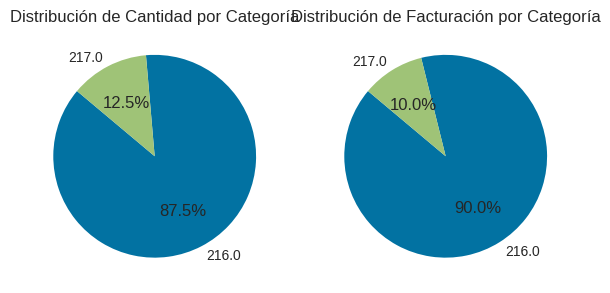

In [19]:
# Distribución de cantidades vendidas y facturacion según categoria del producto

# Agrupa por 'Cat' y calcula la suma de Cantidad y Facturacion
cat_summary = df.groupby('Cat ').agg({'CANTIDAD': 'sum', 'FACTURACION': 'sum'})

cantidad = cat_summary['CANTIDAD']
facturacion = cat_summary['FACTURACION']
categorias = cat_summary.index

plt.figure(figsize=(6, 3))

# Graficar la dona de Cantidad
plt.subplot(121)
plt.pie(cantidad, labels=categorias, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Cantidad por Categoría')

# Graficar la dona de Facturacion
plt.subplot(122)
plt.pie(facturacion, labels=categorias, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de Facturación por Categoría')

plt.tight_layout()
plt.show()

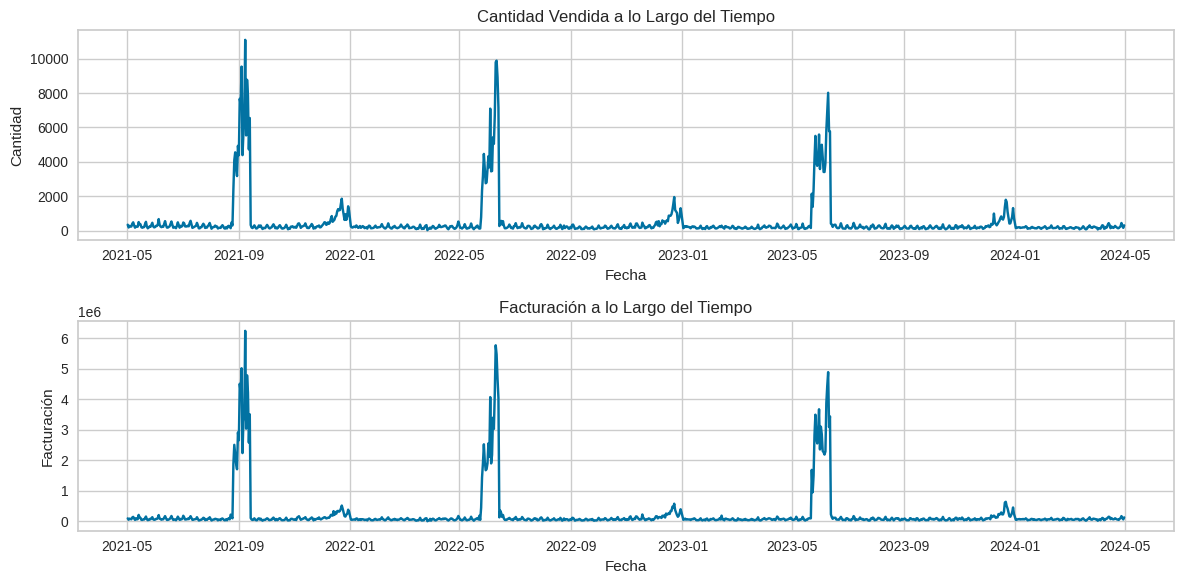

In [20]:
# Gráfico de líneas para la tendencia temporal de las variables Cantidad y Facturación

df['MOVFEC'] = pd.to_datetime(df['MOVFEC'])

# Agrupar por fecha y calcular la suma de CANTIDAD y FACTURACION
time_series = df.groupby('MOVFEC').agg({'CANTIDAD': 'sum', 'FACTURACION': 'sum'})

plt.figure(figsize=(12, 6))

# Graficar CANTIDAD
plt.subplot(211)  # Subplot 1 de 2
plt.plot(time_series.index, time_series['CANTIDAD'], linestyle='-')
plt.title('Cantidad Vendida a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Cantidad')

# Graficar FACTURACION
plt.subplot(212)  # Subplot 2 de 2
plt.plot(time_series.index, time_series['FACTURACION'], linestyle='-')
plt.title('Facturación a lo Largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Facturación')

plt.tight_layout()
plt.show()


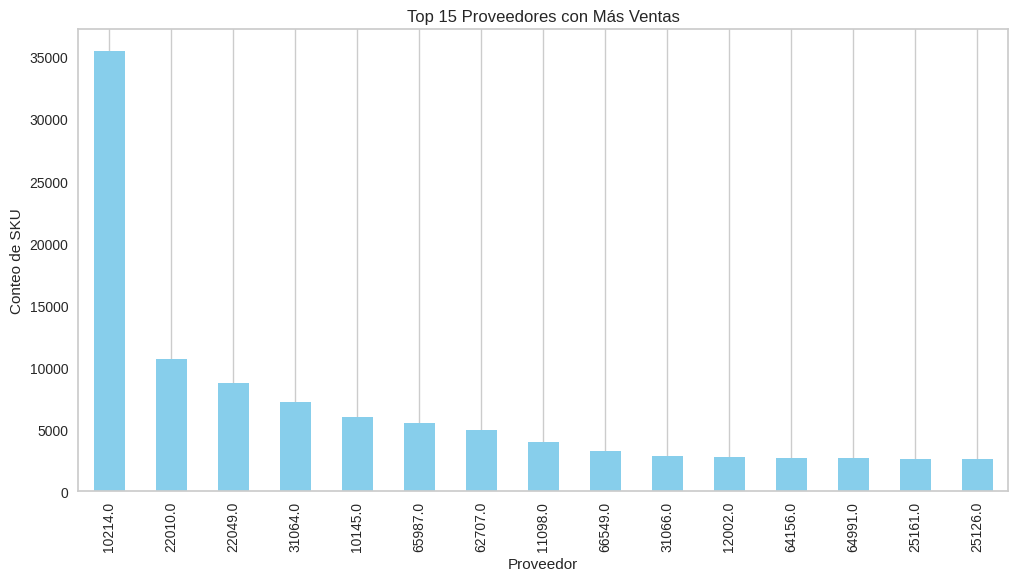

In [21]:
# Gráfico de barras presentando los 15 proveedores con mayores ventas de SKUs

# Calcular el conteo de SKU por proveedor
prov_count = df.groupby('Prov').size()

# Ordenar los proveedores por el conteo de SKU en orden descendente y seleccionar los 15 primeros
top_providers = prov_count.sort_values(ascending=False).head(15)

# Generar el gráfico de barras solo para los 15 mejores proveedores
plt.figure(figsize=(12, 6))
top_providers.plot(kind='bar', color='skyblue')
plt.xlabel('Proveedor')
plt.ylabel('Conteo de SKU')
plt.title('Top 15 Proveedores con Más Ventas')
plt.grid(axis='y')

plt.show()


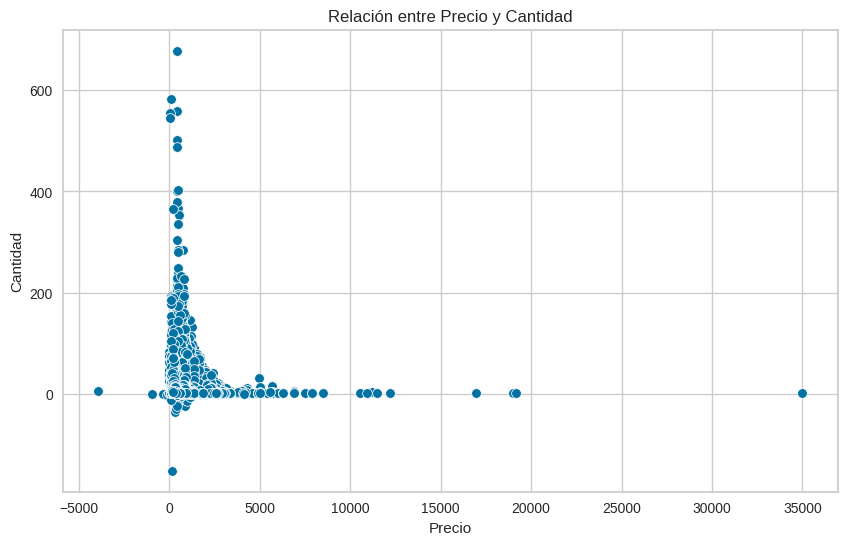

In [22]:
# Gráfico de dispersión para visualizar relación entre precio y cantidad

plt.figure(figsize=(10, 6))

# Graficar el scatter plot
sns.scatterplot(x='PRECIO', y='CANTIDAD', data=df)
plt.title('Relación entre Precio y Cantidad')
plt.xlabel('Precio')
plt.ylabel('Cantidad')

plt.show()


### **PREPARACIÓN DE LOS DATOS PARA EL MODELO**


In [23]:
# Calcula el promedio móvil con una ventana de 3 días para cada SKU

df['promedio_movil_3'] = df.groupby('SKU')['CANTIDAD'].rolling(window=3).mean().reset_index(level=0, drop=True)
df['promedio_movil_3'] = df['promedio_movil_3'].fillna(0)

In [24]:
# Calcula el promedio móvil con una ventana de 7 días para cada SKU

df['promedio_movil_7'] = df.groupby('SKU')['CANTIDAD'].rolling(window=7).mean().reset_index(level=0, drop=True)
df['promedio_movil_7'] = df['promedio_movil_7'].fillna(0)

In [25]:
# Calcula el promedio móvil con una ventana de 15 días para cada SKU

df['promedio_movil_15'] = df.groupby('SKU')['CANTIDAD'].rolling(window=15).mean().reset_index(level=0, drop=True)
df['promedio_movil_15'] = df['promedio_movil_15'].fillna(0)

In [26]:
# Carga de sets con datos sobre Temperatura y Humedad

temp_2021 = pd.read_csv("2021_Temp.csv")
temp_2022 = pd.read_csv("2022_Temp.csv")
temp_2023 = pd.read_csv("2023_Temp.csv")
temp_2024 = pd.read_csv("2024_Temp.csv")
hum_2021 = pd.read_csv("2021_Hum.csv")
hum_2022 = pd.read_csv("2022_Hum.csv")
hum_2023 = pd.read_csv("2023_Hum.csv")
hum_2024 = pd.read_csv("2024_Hum.csv")

In [27]:
# Creación de df_temperatura

df_temperatura = pd.concat([temp_2021, temp_2022, temp_2023, temp_2024], ignore_index=True)

In [28]:
# Creación de df_humedad

df_humedad = pd.concat([hum_2021, hum_2022, hum_2023, hum_2024], ignore_index=True)

In [29]:
# Convertir el dato fecha en datetime

df_temperatura['fecha'] = pd.to_datetime(df_temperatura['fecha'])

# Extraer solo la parte de la fecha manteniendo el tipo datetime64
df_temperatura['fecha'] = df_temperatura['fecha'].dt.normalize()

# Agrupar los datos por fecha y obtener el valor máximo de HumRelativa para cada día

df_max_temp = df_temperatura.groupby('fecha')['TempAire'].max().reset_index()
df_temp = df_max_temp
df_temp

,fecha,TempAire
0,2021-01-01,28.6
1,2021-01-02,31.2
2,2021-01-03,29.4
3,2021-01-04,28.9
4,2021-01-05,29.7
...,...,...
1153,2024-02-28,28.7
1154,2024-02-29,28.2
1155,2024-03-01,27.8
1156,2024-03-02,25.9


In [30]:
# Convertir el dato fecha en datetime
df_humedad['fecha'] = pd.to_datetime(df_humedad['fecha'])

# Extraer solo la parte de la fecha manteniendo el tipo datetime64
df_humedad['fecha'] = df_humedad['fecha'].dt.normalize()

# Agrupar los datos por fecha y obtener el valor máximo de HumRelativa para cada día
df_max_hum = df_humedad.groupby('fecha')['HumRelativa'].max().reset_index()
df_hum = df_max_hum
df_hum

,fecha,HumRelativa
0,2021-01-01,72.0
1,2021-01-02,88.0
2,2021-01-03,83.0
3,2021-01-04,92.0
4,2021-01-05,93.0
...,...,...
1153,2024-02-28,100.0
1154,2024-02-29,95.0
1155,2024-03-01,86.0
1156,2024-03-02,98.0


In [31]:
# Creación de df_lluvias

df_lluvias = pd.read_excel("Lluvias.xlsx")

In [32]:
# Se elimina la variable precipitacion acumulada

df_lluvias = df_lluvias.drop(columns=['Precipitación Acumulada mm'])

In [33]:
df_lluvias.rename(columns={'Fecha': 'fecha'}, inplace=True)

In [34]:
# Merge de df_temperatura y df_humedad

df_clima = pd.merge(df_temp, df_hum, on=['fecha'])

In [35]:
# Merge de df_clima y df_lluvias

df_clima = pd.merge(df_clima, df_lluvias, on=['fecha'])

In [36]:
# Merge df con df_clima

df= pd.merge(df, df_clima, left_on='MOVFEC', right_on='fecha', how='left')

In [37]:
# Se elimina varibale fecha
df= df.drop(columns=['fecha'])

In [38]:
# Se crean variables con ventas de dias anteriores (lags) y la variable target: venta_15_dias_adelante

df = df.sort_values(by=['SKU', 'MOVFEC'])

def calculate_lag(df, days):
    result = []
    for idx in range(len(df)):
        current_date = df.iloc[idx]['MOVFEC']
        lag_date = current_date - pd.Timedelta(days=days)
        mask = (df['MOVFEC'] == lag_date) & (df['SKU'] == df.iloc[idx]['SKU'])
        if mask.any():
            result.append(df[mask]['CANTIDAD'].values[0])
        else:
            result.append(0)
    return result

df['venta_dia_anterior'] = calculate_lag(df, 1)
df['venta_2_dias_atras'] = calculate_lag(df, 2)
df['venta_3_dias_atras'] = calculate_lag(df, 3)
df['venta_4_dias_atras'] = calculate_lag(df, 4)
df['venta_5_dias_atras'] = calculate_lag(df, 5)
df['venta_6_dias_atras'] = calculate_lag(df, 6)
df['venta_7_dias_atras'] = calculate_lag(df, 7)
df['venta_14_dias_atras'] = calculate_lag(df, 14)
df['venta_365_dias_atras'] = calculate_lag(df, 365)
df['venta_15_dias_adelante'] = calculate_lag(df, -15)

print(df)


           MOVFEC     SKU  CANTIDAD  FACTURACION  Status Hoy     Prov   Cat   \
100652 2023-05-23  306252        33         0.33         5.0  13016.0  216.0   
100904 2023-05-24  306252        26         0.26         5.0  13016.0  216.0   
101065 2023-05-25  306252        46         0.46         5.0  13016.0  216.0   
101240 2023-05-26  306252        51         0.51         5.0  13016.0  216.0   
101573 2023-05-27  306252        80         0.80         5.0  13016.0  216.0   
...           ...     ...       ...          ...         ...      ...    ...   
126443 2023-11-29  660998         1       275.00         5.0  11094.0  216.0   
128313 2023-12-13  660998         1       275.00         5.0  11094.0  216.0   
129055 2023-12-17  660998         2       550.00         5.0  11094.0  216.0   
129987 2023-12-22  660998         1       275.00         5.0  11094.0  216.0   
130334 2023-12-23  660998         1       275.00         5.0  11094.0  216.0   

        Tipo Prov  DISCOUNT  PRECIO  ..

In [39]:
# Se generan variables adicionales para el modelo

def build_temporal_features(date_variable: str, df: pd.DataFrame) -> pd.DataFrame:

    df.sort_values(by=date_variable, ascending=False)

    df['day_of_month'] = df[date_variable].dt.day - 1
    df['month'] = df[date_variable].dt.month - 1  # Jan = 0
    df['day_of_week'] = df[date_variable].dt.dayofweek
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['day_of_month_sin'] = np.sin(2 * np.pi * df['day_of_month'] / 31)
    df['day_of_month_cos'] = np.cos(2 * np.pi * df['day_of_month'] / 31)

    return df

In [40]:
# Adición de variables al df

df  = build_temporal_features('MOVFEC', df)
df

,MOVFEC,SKU,CANTIDAD,FACTURACION,Status Hoy,Prov,Cat,Tipo Prov,DISCOUNT,PRECIO,...,venta_15_dias_adelante,day_of_month,month,day_of_week,day_of_week_sin,day_of_week_cos,month_cos,month_sin,day_of_month_sin,day_of_month_cos
100652,2023-05-23,306252,33,0.33,5.0,13016.0,216.0,1.0,0,0.01,...,40,22,4,1,0.781831,0.623490,-0.500000,0.866025,-0.968077,-0.250653
100904,2023-05-24,306252,26,0.26,5.0,13016.0,216.0,1.0,0,0.01,...,48,23,4,2,0.974928,-0.222521,-0.500000,0.866025,-0.998717,-0.050649
101065,2023-05-25,306252,46,0.46,5.0,13016.0,216.0,1.0,0,0.01,...,83,24,4,3,0.433884,-0.900969,-0.500000,0.866025,-0.988468,0.151428
101240,2023-05-26,306252,51,0.51,5.0,13016.0,216.0,1.0,0,0.01,...,82,25,4,4,-0.433884,-0.900969,-0.500000,0.866025,-0.937752,0.347305
101573,2023-05-27,306252,80,0.80,5.0,13016.0,216.0,1.0,0,0.01,...,63,26,4,5,-0.974928,-0.222521,-0.500000,0.866025,-0.848644,0.528964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126443,2023-11-29,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,0,28,10,2,0.974928,-0.222521,0.500000,-0.866025,-0.571268,0.820763
128313,2023-12-13,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,0,12,11,2,0.974928,-0.222521,0.866025,-0.500000,0.651372,-0.758758
129055,2023-12-17,660998,2,550.00,5.0,11094.0,216.0,1.0,0,275.00,...,0,16,11,6,-0.781831,0.623490,0.866025,-0.500000,-0.101168,-0.994869
129987,2023-12-22,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,0,21,11,4,-0.433884,-0.900969,0.866025,-0.500000,-0.897805,-0.440394


In [41]:
# Se agrupan los productos según precio para agregar como variable

df['precio_categoria'] = pd.qcut(df['PRECIO'], q=3, labels=[1, 2, 3])

In [42]:
# Se agrupan los productos según cantidad y día de venta para agregar como variable

# Calcular la cantidad total vendida por día de la semana
cantidad_por_dia = df.groupby('day_of_week')['CANTIDAD'].sum().reset_index()

# Ordenar los días de la semana asumiendo que 0 es Lunes y 6 es Domingo
dias_orden = [0, 1, 2, 3, 4, 5, 6]
cantidad_por_dia['day_of_week'] = pd.Categorical(cantidad_por_dia['day_of_week'], categories=dias_orden, ordered=True)
cantidad_por_dia = cantidad_por_dia.sort_values('day_of_week')

print(cantidad_por_dia)

  day_of_week  CANTIDAD
0           0     67517
1           1     57518
2           2     66530
3           3     76159
4           4     97954
5           5    116567
6           6     81824


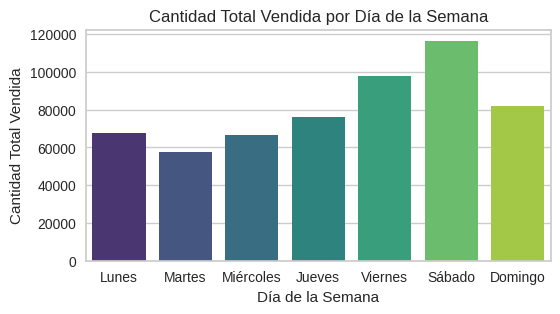

In [43]:
# Crear el gráfico de barras
plt.figure(figsize=(6, 3))
sns.barplot(x='day_of_week', y='CANTIDAD', data=cantidad_por_dia, palette='viridis')

plt.title('Cantidad Total Vendida por Día de la Semana')
plt.xlabel('Día de la Semana')
plt.ylabel('Cantidad Total Vendida')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo'])

plt.show()

In [44]:
# Crear una nueva columna 'categoria_demanda' basada en el día de la semana
def clasificar_demanda(dia):
    if dia in [3, 4, 5]:
        return 1
    else:
        return 0

df['categoria_demanda'] = df['day_of_week'].apply(clasificar_demanda)

In [45]:
# Verificación de nulos

if df.isnull().values.any():
    print("Hay valores nulos en el DataFrame.")
else:
    print("No hay valores nulos en el DataFrame.")

Hay valores nulos en el DataFrame.


In [46]:
# Verificación de nulos

print(df[df.isna().any(axis=1)])
print(df.isna().sum())

           MOVFEC     SKU  CANTIDAD  FACTURACION  Status Hoy     Prov   Cat   \
143690 2024-04-20  542168         2        376.0         5.0  65733.0  217.0   
144314 2024-04-26  542168         2        376.0         5.0  65733.0  217.0   
92453  2023-03-12  542169         0          0.0         5.0  65733.0  217.0   
138903 2024-03-09  542170         1        192.0         1.0  65733.0  217.0   
139593 2024-03-16  542170         2        384.0         1.0  65733.0  217.0   
...           ...     ...       ...          ...         ...      ...    ...   
143621 2024-04-20  660995         1        295.0         1.0  11094.0  216.0   
139561 2024-03-16  660996         1        275.0         1.0  11094.0  216.0   
140036 2024-03-21  660996         1        275.0         1.0  11094.0  216.0   
142480 2024-04-12  660996         1        275.0         1.0  11094.0  216.0   
144313 2024-04-26  660996         1        275.0         1.0  11094.0  216.0   

        Tipo Prov  DISCOUNT  PRECIO  ..

In [47]:
# Se eliminan los valores NA

df = df.dropna()

In [48]:
# Crear un filtro para identificar filas donde CANTIDAD y FACTURACION son menor o iguales que 0.1
#(se encontró un SKU que facturaba importes menores a 0.1 pudiendo tratarse de diferencias de inventario)

df_mod = (df[['CANTIDAD', 'FACTURACION']] > 0.1).all(axis=1)

# Aplicar el filtro para eliminar las filas
df = df[df_mod]

In [49]:
# Calculamos el acumulado móvil con una ventana de 3 días

df['acumulado_movil_3'] = df.groupby('SKU')['CANTIDAD'].rolling(window=3).sum().reset_index(level=0, drop=True)
df['acumulado_movil_3'] = df['acumulado_movil_3'].fillna(0)

In [50]:
# Calculamos el acumulado móvil con una ventana de 7 días

df['acumulado_movil_7'] = df.groupby('SKU')['CANTIDAD'].rolling(window=7).sum().reset_index(level=0, drop=True)
df['acumulado_movil_7'] = df['acumulado_movil_7'].fillna(0)

In [51]:
# Calculamos el acumulado móvil con una ventana de 15 días

df['acumulado_movil_15'] = df.groupby('SKU')['CANTIDAD'].rolling(window=15).sum().reset_index(level=0, drop=True)
df['acumulado_movil_15'] = df['acumulado_movil_15'].fillna(0)

In [52]:
# Crear la columna 'Festividad' que indique 1 si el mes es diciembre, de lo contrario 0
df['Festividad'] = df['MOVFEC'].apply(lambda x: 1 if x.month == 12 else 0)

In [57]:
# Verificación de nulos

if df.isnull().values.any():
    print("Hay valores nulos en el DataFrame.")
else:
    print("No hay valores nulos en el DataFrame.")

No hay valores nulos en el DataFrame.


### **GENERACIÓN DE CLUSTERS**
### **1- KMEANS TIMES SERIES**

In [58]:
# Verificación de todas las variables previo a clusterizar

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 137345 entries, 100652 to 130334
Data columns (total 42 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   MOVFEC                     137345 non-null  datetime64[ns]
 1   SKU                        137345 non-null  int64         
 2   CANTIDAD                   137345 non-null  int64         
 3   FACTURACION                137345 non-null  float64       
 4   Status Hoy                 137345 non-null  float64       
 5   Prov                       137345 non-null  float64       
 6   Cat                        137345 non-null  float64       
 7   Tipo Prov                  137345 non-null  float64       
 8   DISCOUNT                   137345 non-null  int64         
 9   PRECIO                     137345 non-null  float64       
 10  promedio_movil_3           137345 non-null  float64       
 11  promedio_movil_7           137345 non-null  float64 

In [59]:
# Eliminar la columna MOVFEC para el clustering
df_cluster = df.drop(columns=['MOVFEC'])

# Asegurarse de que todas las columnas sean numéricas
df_cluster = df_cluster.astype(float)

# Verificar y reemplazar valores infinitos y demasiado grandes
df_cluster.replace([np.inf, -np.inf], np.nan, inplace=True)
df_cluster.dropna(inplace=True)

# TimeSeriesKMeans clustering
cluster_count = 4
km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

# Reestructurar el DataFrame para TimeSeriesKMeans
df_values = df_cluster.values.reshape((df_cluster.shape[0], df_cluster.shape[1], 1))

# Ajustar y predecir
labels = km.fit_predict(df_values)

# Agregar las etiquetas como una nueva columna en el DataFrame original
df['Cluster_Labels'] = np.nan
df.loc[df_cluster.index, 'Cluster_Labels'] = labels

print(df)

           MOVFEC     SKU  CANTIDAD  FACTURACION  Status Hoy     Prov   Cat   \
100652 2023-05-23  306252        33         0.33         5.0  13016.0  216.0   
100904 2023-05-24  306252        26         0.26         5.0  13016.0  216.0   
101065 2023-05-25  306252        46         0.46         5.0  13016.0  216.0   
101240 2023-05-26  306252        51         0.51         5.0  13016.0  216.0   
101573 2023-05-27  306252        80         0.80         5.0  13016.0  216.0   
...           ...     ...       ...          ...         ...      ...    ...   
126443 2023-11-29  660998         1       275.00         5.0  11094.0  216.0   
128313 2023-12-13  660998         1       275.00         5.0  11094.0  216.0   
129055 2023-12-17  660998         2       550.00         5.0  11094.0  216.0   
129987 2023-12-22  660998         1       275.00         5.0  11094.0  216.0   
130334 2023-12-23  660998         1       275.00         5.0  11094.0  216.0   

        Tipo Prov  DISCOUNT  PRECIO  ..

### **2- KMEANS**

In [72]:
from pycaret.clustering import *

In [73]:
exp_clu101 = setup(df, normalize = True,
                   session_id = 123)

,Description,Value
0,Session id,123
1,Original data shape,"(137345, 43)"
2,Transformed data shape,"(137345, 47)"
3,Numeric features,41
4,Date features,1
5,Categorical features,1
6,Preprocess,True
7,Imputation type,simple
8,Numeric imputation,mean
9,Categorical imputation,mode


In [74]:
kmeans = create_model('kmeans')

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.0771,13522.3212,2.6149,0,0,0


Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Exception ignored in: <function ZipFile.__del__ at 0x7dec3cfb0820>
Traceback (most recent call last):
  File "/usr/lib/python3.10/zipfile.py", line 1821, in __del__
    self.close()
  File "/usr/lib/python3.10/zipfile.py", line 1838, in close
    self.fp.seek(self.start_dir)
ValueError: seek of closed file


In [75]:
df_clustered = assign_model(kmeans)

In [76]:
df_clustered

,MOVFEC,SKU,CANTIDAD,FACTURACION,Status Hoy,Prov,Cat,Tipo Prov,DISCOUNT,PRECIO,...,day_of_month_sin,day_of_month_cos,precio_categoria,categoria_demanda,acumulado_movil_3,acumulado_movil_7,acumulado_movil_15,Festividad,Cluster_Labels,Cluster
100652,2023-05-23,306252,33,0.33,5.0,13016.0,216.0,1.0,0,0.01,...,-0.968077,-0.250653,1,0,0.0,0.0,0.0,0,0.0,Cluster 3
100904,2023-05-24,306252,26,0.26,5.0,13016.0,216.0,1.0,0,0.01,...,-0.998717,-0.050649,1,0,0.0,0.0,0.0,0,0.0,Cluster 3
101065,2023-05-25,306252,46,0.46,5.0,13016.0,216.0,1.0,0,0.01,...,-0.988468,0.151428,1,1,105.0,0.0,0.0,0,0.0,Cluster 3
101240,2023-05-26,306252,51,0.51,5.0,13016.0,216.0,1.0,0,0.01,...,-0.937752,0.347305,1,1,123.0,0.0,0.0,0,0.0,Cluster 3
101573,2023-05-27,306252,80,0.80,5.0,13016.0,216.0,1.0,0,0.01,...,-0.848644,0.528964,1,1,177.0,0.0,0.0,0,0.0,Cluster 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126443,2023-11-29,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,-0.571268,0.820763,1,0,3.0,7.0,19.0,0,1.0,Cluster 3
128313,2023-12-13,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,0.651372,-0.758758,1,0,3.0,7.0,15.0,1,1.0,Cluster 2
129055,2023-12-17,660998,2,550.00,5.0,11094.0,216.0,1.0,0,275.00,...,-0.101168,-0.994869,1,0,4.0,8.0,16.0,1,1.0,Cluster 3
129987,2023-12-22,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,-0.897805,-0.440394,1,1,4.0,8.0,16.0,1,1.0,Cluster 3


In [77]:
# Supongamos que df_clustered ya está definido y contiene la columna 'Cluster'
# Verifica si los valores son cadenas y conviértelos
if df_clustered['Cluster'].dtype == object:
    df_clustered['Cluster'] = df_clustered['Cluster'].apply(lambda x: int(x.split()[1]) if isinstance(x, str) else x)
df_clustered


,MOVFEC,SKU,CANTIDAD,FACTURACION,Status Hoy,Prov,Cat,Tipo Prov,DISCOUNT,PRECIO,...,day_of_month_sin,day_of_month_cos,precio_categoria,categoria_demanda,acumulado_movil_3,acumulado_movil_7,acumulado_movil_15,Festividad,Cluster_Labels,Cluster
100652,2023-05-23,306252,33,0.33,5.0,13016.0,216.0,1.0,0,0.01,...,-0.968077,-0.250653,1,0,0.0,0.0,0.0,0,0.0,3
100904,2023-05-24,306252,26,0.26,5.0,13016.0,216.0,1.0,0,0.01,...,-0.998717,-0.050649,1,0,0.0,0.0,0.0,0,0.0,3
101065,2023-05-25,306252,46,0.46,5.0,13016.0,216.0,1.0,0,0.01,...,-0.988468,0.151428,1,1,105.0,0.0,0.0,0,0.0,3
101240,2023-05-26,306252,51,0.51,5.0,13016.0,216.0,1.0,0,0.01,...,-0.937752,0.347305,1,1,123.0,0.0,0.0,0,0.0,3
101573,2023-05-27,306252,80,0.80,5.0,13016.0,216.0,1.0,0,0.01,...,-0.848644,0.528964,1,1,177.0,0.0,0.0,0,0.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126443,2023-11-29,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,-0.571268,0.820763,1,0,3.0,7.0,19.0,0,1.0,3
128313,2023-12-13,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,0.651372,-0.758758,1,0,3.0,7.0,15.0,1,1.0,2
129055,2023-12-17,660998,2,550.00,5.0,11094.0,216.0,1.0,0,275.00,...,-0.101168,-0.994869,1,0,4.0,8.0,16.0,1,1.0,3
129987,2023-12-22,660998,1,275.00,5.0,11094.0,216.0,1.0,0,275.00,...,-0.897805,-0.440394,1,1,4.0,8.0,16.0,1,1.0,3


In [78]:
#plot_model(kmeans, plot = 'silhouette')

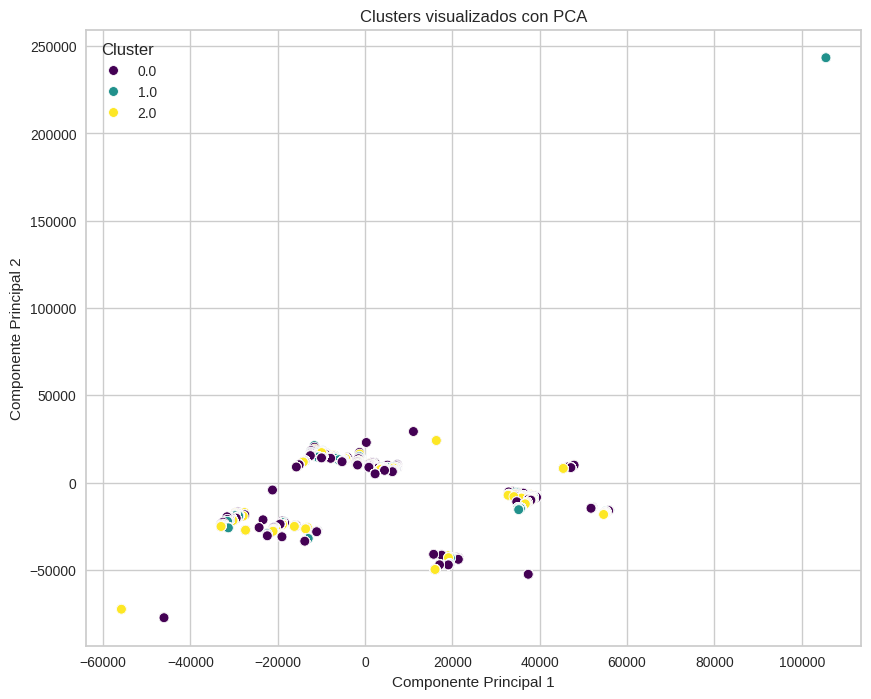

In [79]:
# Gráfico de los clusters

df_cluster = df_clustered.copy()
df_cluster = df_cluster.drop(columns=['MOVFEC'])

# Seleccionamos las características para PCA, excluyendo la columna de etiquetas de cluster
features = df_cluster

# Realizamos PCA para reducir a 2 componentes principales
pca = PCA(n_components=2)
principal_components = pca.fit_transform(features)

# Creamos un DataFrame con las componentes principales
df_pca = pd.DataFrame(data=principal_components, columns=['PCA1', 'PCA2'])
df_pca['Cluster_Labels'] = df.loc[df_cluster.index, 'Cluster_Labels']

# Graficamos los clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster_Labels', palette='viridis', data=df_pca, s=50)
plt.title('Clusters visualizados con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.show()

In [82]:
# Se renombra df

df = df_clustered

In [119]:
# Se filtra el df según los clusters generados

grouped = df.groupby('Cluster')

df_cluster_0 = grouped.get_group(0)
df_cluster_1 = grouped.get_group(1)
df_cluster_2 = grouped.get_group(2)
df_cluster_3 = grouped.get_group(3)


### **MODELOS DE PREDICCIÓN DE LA DEMANDA POR CLUSTERS**

In [84]:
# Variables a ignorar por los modelos

colIgnore = ['MOVFEC', 'FACTURACION']

In [85]:
from pycaret.regression import *

#### **CLUSTER 0**

In [86]:
exp_cluster_0 = setup(data=df_cluster_0,
                 target='venta_15_dias_adelante',
                 ignore_features=colIgnore,
                 fold=10,
                 normalize=True,
                 session_id=123)

,Description,Value
0,Session id,123
1,Target,venta_15_dias_adelante
2,Target type,Regression
3,Original data shape,"(33521, 44)"
4,Transformed data shape,"(33521, 44)"
5,Transformed train set shape,"(23464, 44)"
6,Transformed test set shape,"(10057, 44)"
7,Ignore features,2
8,Numeric features,40
9,Categorical features,1


In [87]:
best_model_cluster_0 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8490,4.5607,2.1238,0.2369,0.5151,0.6612,4.1310
gbr,Gradient Boosting Regressor,0.8719,4.8182,2.1793,0.2008,0.5283,0.6347,5.7430
rf,Random Forest Regressor,0.9079,4.8743,2.1948,0.1851,0.5454,0.6503,26.7680
xgboost,Extreme Gradient Boosting,0.8837,5.1590,2.2622,0.1262,0.5361,0.7140,0.8860
ridge,Ridge Regression,0.9471,5.2835,2.2833,0.1225,0.5644,0.6265,0.1890
br,Bayesian Ridge,0.9458,5.2843,2.2834,0.1225,0.5637,0.6236,0.2290
lr,Linear Regression,0.9474,5.2836,2.2833,0.1225,0.5647,0.6272,1.1650
et,Extra Trees Regressor,0.9161,5.3736,2.3058,0.0948,0.5511,0.6546,15.8590
omp,Orthogonal Matching Pursuit,0.9676,5.5992,2.3504,0.0707,0.5786,0.5880,0.3580
knn,K Neighbors Regressor,0.8948,5.8646,2.4048,0.0256,0.5722,0.7621,0.5910


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [88]:
print(best_model_cluster_0)

LGBMRegressor(n_jobs=-1, random_state=123)


In [89]:
model_cluster_0 = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.8612,5.4979,2.3448,0.2374,0.5196,0.6854
1,0.7801,2.8693,1.6939,0.2622,0.5031,0.6384
2,0.8048,3.4001,1.8439,0.1753,0.5128,0.6738
3,0.8475,5.0353,2.2440,0.1982,0.5121,0.6429
4,0.8785,5.9275,2.4346,0.1891,0.5211,0.6459
5,0.8870,4.0830,2.0206,0.1288,0.5313,0.7248
6,0.8610,4.6017,2.1452,0.2359,0.5219,0.6527
7,0.8576,5.4362,2.3316,0.3287,0.5031,0.6598
8,0.8326,3.9432,1.9857,0.2891,0.5123,0.6383


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [90]:
evaluacion_cluster_0 = evaluate_model(model_cluster_0)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [91]:
predicciones_cluster_0 = predict_model(model_cluster_0)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.8714,4.4325,2.1054,0.2984,0.5193,0.6252


In [92]:
predicciones_cluster_0

,SKU,CANTIDAD,Status Hoy,Prov,Cat,Tipo Prov,DISCOUNT,PRECIO,promedio_movil_3,promedio_movil_7,...,precio_categoria,categoria_demanda,acumulado_movil_3,acumulado_movil_7,acumulado_movil_15,Festividad,Cluster_Labels,Cluster,venta_15_dias_adelante,prediction_label
91314,562204,1,1.0,66033.0,216.0,1.0,0,799.0,1.000000,1.142857,...,3,0,3.0,8.0,17.0,0,2.0,0,0,-0.002152
134936,562672,1,5.0,66180.0,216.0,1.0,0,440.0,1.000000,1.000000,...,3,1,3.0,7.0,18.0,0,2.0,0,0,0.053352
91237,566449,1,1.0,10367.0,217.0,1.0,0,80.0,1.000000,1.428571,...,1,0,3.0,10.0,117.0,0,0.0,0,0,0.162589
100399,560415,4,5.0,13016.0,216.0,1.0,0,225.0,2.000000,1.571429,...,1,0,6.0,11.0,28.0,0,0.0,0,0,0.627529
92345,560069,2,5.0,18204.0,216.0,1.0,0,147.0,1.333333,1.142857,...,1,1,4.0,8.0,30.0,0,0.0,0,0,0.547741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133419,562930,1,1.0,12044.0,216.0,1.0,0,439.0,1.333333,1.428571,...,2,0,4.0,10.0,21.0,0,0.0,0,0,0.379930
38166,562257,2,1.0,62707.0,216.0,1.0,0,449.0,1.333333,2.714286,...,3,1,4.0,19.0,43.0,0,2.0,0,1,0.709860
99632,560977,1,1.0,22049.0,216.0,1.0,1,505.0,1.333333,1.142857,...,3,0,4.0,8.0,29.0,0,0.0,0,18,11.975633
43492,560309,1,1.0,11056.0,216.0,1.0,0,245.0,1.000000,1.142857,...,1,1,3.0,8.0,32.0,0,0.0,0,0,0.467623


In [93]:
y_pred_cluster_0 = predicciones_cluster_0['prediction_label']

In [94]:
y_test_cluster_0=predicciones_cluster_0['venta_15_dias_adelante']

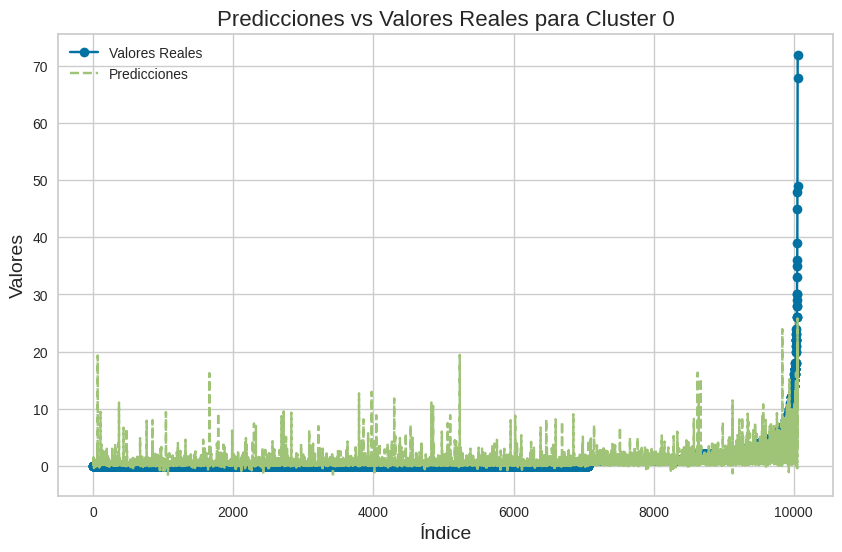

In [118]:
# Se grafican los valores reales vs predicciones

# Obtener predicciones del mejor modelo
predictions_cluster_0 = predicciones_cluster_0[['venta_15_dias_adelante', 'prediction_label']]

# Ordenar los datos por valores reales
predictions_cluster_0 = predictions_cluster_0.sort_values(by='venta_15_dias_adelante').reset_index(drop=True)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(predictions_cluster_0['venta_15_dias_adelante'], label='Valores Reales', linestyle='-', marker='o')
plt.plot(predictions_cluster_0['prediction_label'], label='Predicciones', linestyle='--', marker='x')

plt.title('Predicciones vs Valores Reales para Cluster 0', fontsize=16)
plt.xlabel('Índice', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()


#### **CLUSTER 1**

In [96]:
exp_cluster_1 = setup(data=df_cluster_1,
                 target='venta_15_dias_adelante',
                 ignore_features=colIgnore,
                 fold=10,
                 normalize=True,
                 session_id=123)

,Description,Value
0,Session id,123
1,Target,venta_15_dias_adelante
2,Target type,Regression
3,Original data shape,"(2971, 44)"
4,Transformed data shape,"(2971, 44)"
5,Transformed train set shape,"(2079, 44)"
6,Transformed test set shape,"(892, 44)"
7,Ignore features,2
8,Numeric features,40
9,Categorical features,1


In [97]:
best_model_cluster_1 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,3.3670,139.6103,10.1145,0.6640,0.8969,1.4084,1.9570
et,Extra Trees Regressor,2.7059,125.7810,9.9339,0.6417,0.7345,0.8949,1.1690
xgboost,Extreme Gradient Boosting,2.9953,142.8795,10.7209,0.5551,0.7865,0.9881,0.7610
knn,K Neighbors Regressor,2.9856,186.2704,11.6880,0.5401,0.7432,0.8719,0.0960
rf,Random Forest Regressor,3.2051,178.8039,11.7424,0.4309,0.8079,1.0594,3.5500
gbr,Gradient Boosting Regressor,3.4971,202.3567,12.5714,0.3477,0.8702,1.0116,0.8540
en,Elastic Net,5.9407,320.2867,16.2632,0.1257,1.3364,1.9912,0.1570
lasso,Lasso Regression,6.0673,321.8960,16.3148,0.1176,1.3544,2.0656,0.0900
llar,Lasso Least Angle Regression,6.0673,321.8954,16.3148,0.1176,1.3544,2.0656,0.1190
br,Bayesian Ridge,7.3005,305.6822,16.1138,0.1005,1.5413,3.0008,0.0980


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [98]:
print(best_model_cluster_1)

LGBMRegressor(n_jobs=-1, random_state=123)


In [100]:
model_cluster_1 = create_model('et')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.3799,54.1181,7.3565,0.7456,0.6881,0.9176
1,3.1917,292.5490,17.1041,0.6683,0.7432,0.8333
2,4.2537,518.1873,22.7637,0.5633,0.7329,0.8645
3,2.2908,48.3919,6.9564,0.1536,0.7470,1.0104
4,2.0864,63.8807,7.9925,0.7264,0.6917,0.7208
5,2.7551,62.6638,7.9160,0.7431,0.8350,0.6829
6,2.5700,74.1709,8.6123,0.4970,0.6862,0.9174
7,2.6329,41.1882,6.4178,0.8071,0.7365,0.7368
8,2.7932,63.8795,7.9925,0.6504,0.7828,1.0134


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [101]:
evaluacion_cluster_1 = evaluate_model(model_cluster_1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [102]:
predicciones_cluster_1 = predict_model(model_cluster_1)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,2.8968,271.8024,16.4864,0.5573,0.6897,0.9017


In [103]:
predicciones_cluster_1

,SKU,CANTIDAD,Status Hoy,Prov,Cat,Tipo Prov,DISCOUNT,PRECIO,promedio_movil_3,promedio_movil_7,...,precio_categoria,categoria_demanda,acumulado_movil_3,acumulado_movil_7,acumulado_movil_15,Festividad,Cluster_Labels,Cluster,venta_15_dias_adelante,prediction_label
60833,608400,60,1.0,10145.0,216.0,1.0,0,535.000000,54.333332,48.428570,...,3,0,163.0,339.0,454.0,0,1.0,1,0,0.78
106448,562053,42,5.0,10145.0,216.0,1.0,1,529.000000,35.666668,29.285715,...,3,1,107.0,205.0,466.0,0,0.0,1,0,0.99
107959,560779,56,1.0,10214.0,216.0,1.0,1,245.000000,204.000000,129.285721,...,1,0,612.0,905.0,1612.0,0,0.0,1,7,7.25
57851,562329,32,1.0,22049.0,216.0,1.0,0,636.862488,27.000000,24.285715,...,3,0,81.0,170.0,311.0,0,0.0,1,0,0.49
23374,605097,1,5.0,10145.0,216.0,1.0,0,565.000000,29.333334,74.000000,...,3,1,88.0,518.0,1289.0,0,1.0,1,0,0.76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108619,560849,1,5.0,22010.0,217.0,1.0,0,719.000000,1.666667,36.857143,...,3,1,5.0,258.0,701.0,0,0.0,1,0,0.14
108055,561484,1,1.0,22010.0,216.0,1.0,0,289.000000,25.666666,29.285715,...,2,0,77.0,205.0,464.0,0,0.0,1,1,1.14
106432,561617,25,5.0,22010.0,216.0,1.0,1,289.000000,40.666668,28.571428,...,2,1,122.0,200.0,319.0,0,0.0,1,2,1.80
107099,561737,6,1.0,62707.0,216.0,1.0,1,657.900024,19.333334,30.142857,...,3,1,58.0,211.0,351.0,0,2.0,1,0,0.30


In [104]:
y_pred_cluster_1 = predicciones_cluster_1['prediction_label']

In [105]:
y_test_cluster_1 = predicciones_cluster_1['venta_15_dias_adelante']

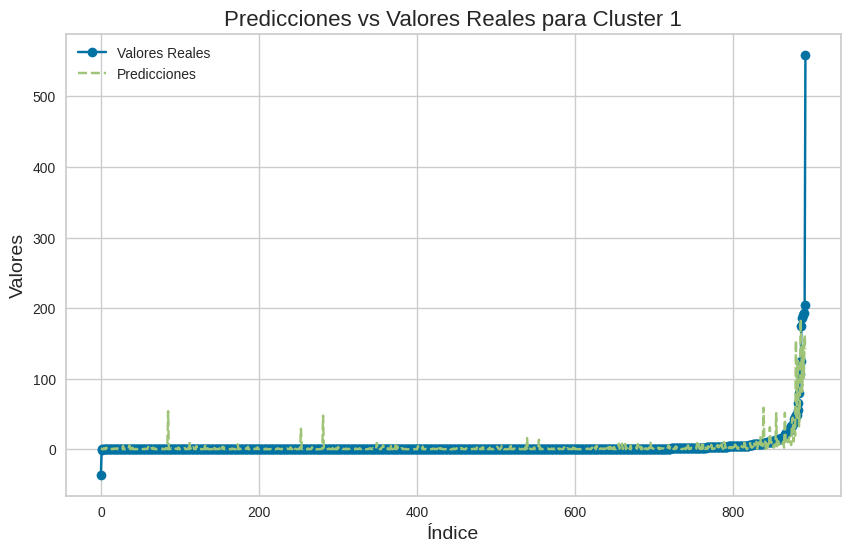

In [106]:
# Se grafican los valores reales vs predicciones

# Obtener predicciones del mejor modelo
predictions_cluster_1 = predicciones_cluster_1[['venta_15_dias_adelante', 'prediction_label']]

# Ordenar los datos por valores reales
predictions_cluster_1 = predictions_cluster_1.sort_values(by='venta_15_dias_adelante').reset_index(drop=True)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(predictions_cluster_1['venta_15_dias_adelante'], label='Valores Reales', linestyle='-', marker='o')
plt.plot(predictions_cluster_1['prediction_label'], label='Predicciones', linestyle='--', marker='x')

plt.title('Predicciones vs Valores Reales para Cluster 1', fontsize=16)
plt.xlabel('Índice', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()


#### **CLUSTER 2**

In [107]:
exp_cluster_2 = setup(data=df_cluster_2,
                 target='venta_15_dias_adelante',
                 ignore_features=colIgnore,
                 fold=10,
                 normalize=True,
                 session_id=123)

,Description,Value
0,Session id,123
1,Target,venta_15_dias_adelante
2,Target type,Regression
3,Original data shape,"(50702, 44)"
4,Transformed data shape,"(50702, 44)"
5,Transformed train set shape,"(35491, 44)"
6,Transformed test set shape,"(15211, 44)"
7,Ignore features,2
8,Numeric features,40
9,Categorical features,1


In [108]:
best_model_cluster_2 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.1362,12.7247,3.5322,0.4594,0.5713,0.7471,24.6140
lightgbm,Light Gradient Boosting Machine,1.1123,12.9803,3.5584,0.4550,0.5543,0.7306,4.8060
rf,Random Forest Regressor,1.1575,13.3525,3.6207,0.4321,0.5749,0.7513,44.7240
xgboost,Extreme Gradient Boosting,1.1972,14.3374,3.7414,0.3983,0.5885,0.8081,1.2340
gbr,Gradient Boosting Regressor,1.2245,15.5537,3.8978,0.3485,0.6033,0.7108,9.7020
knn,K Neighbors Regressor,1.2145,17.3837,4.1375,0.2595,0.6173,0.8378,1.0500
br,Bayesian Ridge,1.6401,21.6399,4.6065,0.0889,0.7766,0.7798,0.3200
lr,Linear Regression,1.6501,21.6443,4.6071,0.0886,0.7802,0.7866,0.4210
ridge,Ridge Regression,1.6500,21.6439,4.6071,0.0886,0.7801,0.7865,0.2670
omp,Orthogonal Matching Pursuit,1.5913,22.1912,4.6659,0.0649,0.7729,0.7360,0.2570


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [109]:
print(best_model_cluster_2)

ExtraTreesRegressor(n_jobs=-1, random_state=123)


In [110]:
model_cluster_2 = create_model('')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.0713,10.0980,3.1777,0.4747,0.5656,0.7081
1,1.1779,13.4006,3.6607,0.3778,0.5767,0.7626
2,1.0371,11.4028,3.3768,0.5739,0.5275,0.7236
3,1.1557,11.3869,3.3744,0.4925,0.5639,0.7418
4,1.1081,10.9590,3.3104,0.4017,0.5535,0.7019
5,1.0429,7.9634,2.8219,0.5054,0.5538,0.8050
6,1.1217,16.0937,4.0117,0.3459,0.5583,0.7418
7,1.0516,8.8402,2.9732,0.4859,0.5453,0.7412
8,1.1573,16.6435,4.0796,0.4907,0.5416,0.6610


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [111]:
evaluacion_cluster_2 = evaluate_model(model_cluster_2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [112]:
predicciones_cluster_2 = predict_model(model_cluster_2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,1.1071,10.5897,3.2542,0.4829,0.5534,0.6971


In [113]:
predicciones_cluster_2

,SKU,CANTIDAD,Status Hoy,Prov,Cat,Tipo Prov,DISCOUNT,PRECIO,promedio_movil_3,promedio_movil_7,...,precio_categoria,categoria_demanda,acumulado_movil_3,acumulado_movil_7,acumulado_movil_15,Festividad,Cluster_Labels,Cluster,venta_15_dias_adelante,prediction_label
61122,601204,3,1.0,10214.0,216.0,1.0,0,359.0,1.666667,1.428571,...,2,0,5.0,10.0,19.0,0,1.0,2,0,0.359258
18445,562218,1,1.0,62707.0,216.0,1.0,1,225.0,7.666667,4.000000,...,1,1,23.0,28.0,37.0,0,2.0,2,1,0.763658
73576,605500,2,1.0,64707.0,216.0,1.0,0,335.0,1.333333,1.285714,...,2,0,4.0,9.0,18.0,0,2.0,2,0,0.206667
124544,604127,2,1.0,11044.0,217.0,1.0,0,190.0,2.000000,1.714286,...,1,1,6.0,12.0,26.0,0,1.0,2,0,0.515755
32395,562639,2,5.0,25005.0,216.0,1.0,0,199.0,1.333333,2.285714,...,1,1,4.0,16.0,36.0,1,0.0,2,0,1.665461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73360,562673,1,1.0,62707.0,216.0,1.0,0,335.0,1.000000,5.000000,...,2,0,3.0,35.0,144.0,0,2.0,2,0,0.138374
29862,560124,17,1.0,25259.0,217.0,1.0,1,599.0,15.333333,15.000000,...,3,1,46.0,105.0,129.0,0,0.0,2,0,3.743337
8790,561058,1,1.0,10214.0,216.0,1.0,0,475.0,1.000000,1.142857,...,3,1,3.0,8.0,0.0,0,0.0,2,0,0.306004
81647,560717,1,1.0,10214.0,216.0,1.0,0,485.0,1.000000,1.142857,...,3,0,3.0,8.0,165.0,1,0.0,2,0,0.271474


In [114]:
y_pred_cluster_2 = predicciones_cluster_2['prediction_label']

In [115]:
y_test_cluster_2 = predicciones_cluster_2['venta_15_dias_adelante']

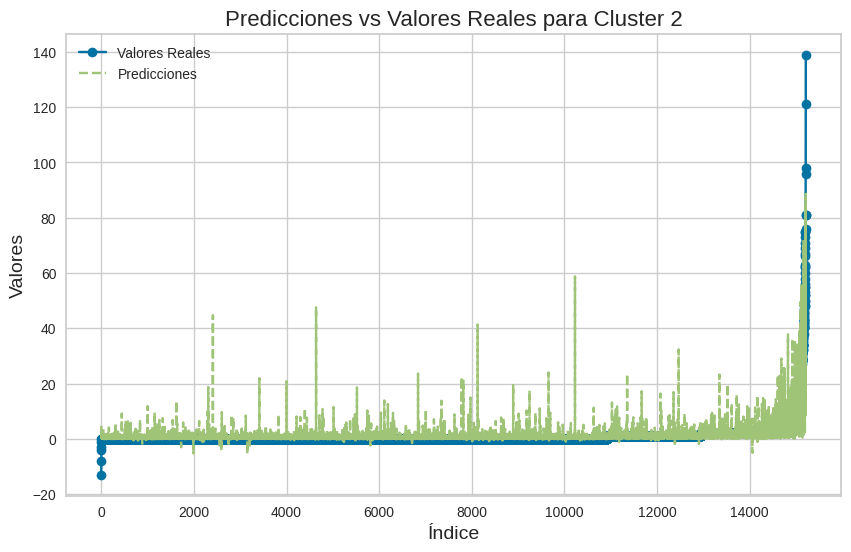

In [116]:
# Se grafican los valores reales vs predicciones

# Obtener predicciones del mejor modelo
predictions_cluster_2 = predicciones_cluster_2[['venta_15_dias_adelante', 'prediction_label']]

# Ordenar los datos por valores reales
predictions_cluster_2 = predictions_cluster_2.sort_values(by='venta_15_dias_adelante').reset_index(drop=True)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(predictions_cluster_2['venta_15_dias_adelante'], label='Valores Reales', linestyle='-', marker='o')
plt.plot(predictions_cluster_2['prediction_label'], label='Predicciones', linestyle='--', marker='x')

plt.title('Predicciones vs Valores Reales para Cluster 2', fontsize=16)
plt.xlabel('Índice', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()


#### **CLUSTER 3**

In [120]:
exp_cluster_3 = setup(data=df_cluster_3,
                 target='venta_15_dias_adelante',
                 ignore_features=colIgnore,
                 fold=10,
                 normalize=True,
                 session_id=123)

,Description,Value
0,Session id,123
1,Target,venta_15_dias_adelante
2,Target type,Regression
3,Original data shape,"(50151, 44)"
4,Transformed data shape,"(50151, 44)"
5,Transformed train set shape,"(35105, 44)"
6,Transformed test set shape,"(15046, 44)"
7,Ignore features,2
8,Numeric features,40
9,Categorical features,1


In [121]:
best_model_cluster_3 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,2.6754,75.9453,8.6839,0.4686,0.7678,1.0112,4.9620
xgboost,Extreme Gradient Boosting,2.9340,79.4150,8.8741,0.4448,0.8336,1.1815,0.8960
rf,Random Forest Regressor,2.7374,79.7756,8.8933,0.4428,0.7697,1.0357,49.8940
et,Extra Trees Regressor,2.6800,80.7123,8.9438,0.4361,0.7491,1.0500,28.0860
gbr,Gradient Boosting Regressor,3.0116,89.2772,9.4116,0.3772,0.8766,1.0169,9.2690
knn,K Neighbors Regressor,2.8317,99.8207,9.9555,0.3020,0.7878,1.1157,0.8300
lr,Linear Regression,4.1595,110.7488,10.4929,0.2260,1.1580,1.5418,0.2770
ridge,Ridge Regression,4.1585,110.7474,10.4928,0.2260,1.1578,1.5410,0.2840
br,Bayesian Ridge,4.1417,110.7437,10.4928,0.2259,1.1539,1.5291,0.4090
lar,Least Angle Regression,4.2503,110.9262,10.5010,0.2248,1.1767,1.6033,0.2450


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [122]:
print(best_model_cluster_3)

LGBMRegressor(n_jobs=-1, random_state=123)


In [124]:
model_cluster_3 = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.9421,87.6828,9.3639,0.4553,0.7970,1.0206
1,2.5476,102.5816,10.1283,0.3700,0.7453,1.0501
2,2.4488,56.2510,7.5001,0.4729,0.7669,1.0331
3,2.9047,81.5146,9.0285,0.4698,0.8016,1.0632
4,2.6260,80.7038,8.9835,0.5302,0.7444,0.9687
5,2.3771,63.9753,7.9985,0.4921,0.7452,0.9776
6,2.7564,68.9099,8.3012,0.4977,0.7638,1.0088
7,2.8582,80.6418,8.9801,0.3849,0.7894,1.0337
8,2.5755,63.9284,7.9955,0.5000,0.7553,0.9728


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [125]:
evaluacion_cluster_3 = evaluate_model(model_cluster_3)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [126]:
predicciones_cluster_3 = predict_model(model_cluster_3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,2.6142,93.9208,9.6913,0.4358,0.7734,1.0015


In [127]:
predicciones_cluster_3

,SKU,CANTIDAD,Status Hoy,Prov,Cat,Tipo Prov,DISCOUNT,PRECIO,promedio_movil_3,promedio_movil_7,...,precio_categoria,categoria_demanda,acumulado_movil_3,acumulado_movil_7,acumulado_movil_15,Festividad,Cluster_Labels,Cluster,venta_15_dias_adelante,prediction_label
115142,560971,1,1.0,10145.0,216.0,1.0,0,675.0,1.666667,1.571429,...,3,0,5.0,11.0,20.0,0,0.0,3,0,5.295647
26533,562467,1,1.0,65987.0,217.0,1.0,0,263.0,2.666667,2.571429,...,1,1,8.0,18.0,60.0,0,2.0,3,3,1.098675
75114,568779,4,5.0,10214.0,216.0,1.0,1,779.0,2.333333,2.285714,...,3,1,7.0,16.0,40.0,0,0.0,3,3,1.935174
31671,562416,4,1.0,10214.0,216.0,1.0,1,319.0,2.666667,1.857143,...,2,0,8.0,13.0,24.0,0,0.0,3,1,1.414045
3306,560101,1,1.0,10214.0,216.0,1.0,0,195.0,1.333333,0.000000,...,1,0,4.0,0.0,0.0,0,0.0,3,0,0.433137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033,607822,1,1.0,10214.0,216.0,1.0,0,329.0,0.000000,0.000000,...,2,1,0.0,0.0,0.0,0,1.0,3,0,1.098177
66162,561706,1,1.0,22231.0,216.0,1.0,0,315.0,1.333333,3.285714,...,2,0,4.0,23.0,57.0,0,0.0,3,0,0.135480
75949,562666,1,1.0,10214.0,217.0,1.0,0,809.0,1.000000,1.142857,...,3,1,3.0,8.0,16.0,0,0.0,3,0,0.486522
122003,560848,3,1.0,31064.0,216.0,1.0,0,169.0,2.000000,1.857143,...,1,0,6.0,13.0,24.0,0,0.0,3,1,1.284816


In [128]:
y_pred_cluster_3 = predicciones_cluster_3['prediction_label']

In [129]:
y_test_cluster_3 = predicciones_cluster_3['venta_15_dias_adelante']

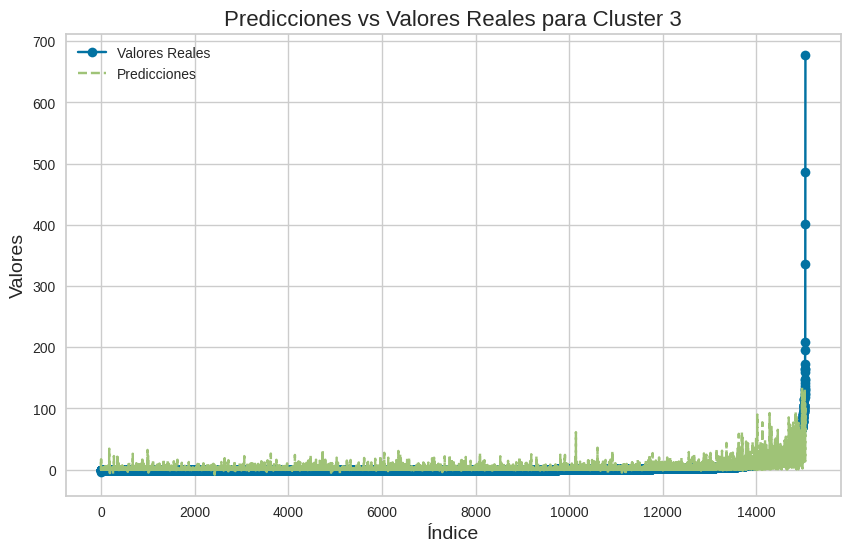

In [130]:
# Se grafican los valores reales vs predicciones

# Obtener predicciones del mejor modelo
predictions_cluster_3 = predicciones_cluster_3[['venta_15_dias_adelante', 'prediction_label']]

# Ordenar los datos por valores reales
predictions_cluster_3 = predictions_cluster_3.sort_values(by='venta_15_dias_adelante').reset_index(drop=True)

# Graficar resultados
plt.figure(figsize=(10, 6))
plt.plot(predictions_cluster_3['venta_15_dias_adelante'], label='Valores Reales', linestyle='-', marker='o')
plt.plot(predictions_cluster_3['prediction_label'], label='Predicciones', linestyle='--', marker='x')

plt.title('Predicciones vs Valores Reales para Cluster 3', fontsize=16)
plt.xlabel('Índice', fontsize=14)
plt.ylabel('Valores', fontsize=14)
plt.legend()
plt.grid(True)

plt.show()
